### Importing Libraries

In [78]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.svm import SVC
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

### Connecting to the database

In [79]:
uri = "bolt://localhost:7687"
username = "neo4j"
password = "OLIV00%%"

driver = GraphDatabase.driver(uri, auth=(username, password))

## Generating graph embeddings 

In [80]:
graph = nx.Graph()

with driver.session() as session:
    nodes_query = "MATCH (n) RETURN ID(n) AS id, n.name AS name, n.type AS type"
    nodes_result = session.run(nodes_query)

    for record in nodes_result:
        node_id = record["id"]
        node_name = record["name"]
        node_type = record["type"]
        if node_id is not None:
            graph.add_node(node_id, name=node_name, type=node_type)

    relations_query = "MATCH ()-[r]->() RETURN ID(startNode(r)) AS source_id, ID(endNode(r)) AS target_id"
    relations_result = session.run(relations_query)

    for record in relations_result:
        source_node_id = record["source_id"]
        target_node_id = record["target_id"]
        if source_node_id is not None and target_node_id is not None:
            graph.add_edge(source_node_id, target_node_id)
            
            
df = pd.DataFrame(graph.nodes(data=True), columns=["node_id", "attributes"])
df["node_type"] = df["attributes"].apply(lambda x: x.get("type"))
df["node_name"] = df["attributes"].apply(lambda x: x.get("name"))

df.drop(columns=["attributes"], inplace=True)

if df.empty:
    raise ValueError("The dataset is empty. Please check your Neo4j query and data.")
    
    
    
# Embeddings #######################################################################
node_embeddings = []

with driver.session() as session:
    # Create a graph projection for link prediction using GDS
    session.run("CALL gds.graph.project('link_prediction_graph', '*', '*')")

with driver.session() as session:
    result = session.run("""
        CALL gds.beta.node2vec.stream('link_prediction_graph', {
            embeddingDimension: 64,
            iterations: 10,
            walkLength: 20,
            inOutFactor: 1.0,
            returnFactor: 1.0
        })
        YIELD nodeId, embedding
        RETURN nodeId, gds.util.asNode(nodeId).name AS node_name, gds.util.asNode(nodeId).type AS node_type, embedding
    """)

    for record in result:
        node_id = record["nodeId"]
        node_name = record["node_name"]
        node_type = record["node_type"]
        embedding = record["embedding"]
        node_embeddings.append((node_id, node_name, node_type, embedding))

columns = ["node_id", "node_name", "node_type", "embedding"]
node_embeddings_df = pd.DataFrame(node_embeddings, columns=columns)
node_embeddings_df.head()

,node_id,node_name,node_type,embedding
0,0,Iv1,fftvInterval,"[-0.0008704315987415612, -0.003447814844548702..."
1,1,Iv2,fftvInterval,"[-0.0003203293599653989, 0.006150012835860252,..."
2,2,Iv3,fftvInterval,"[-0.0006541125476360321, -0.00733681907877326,..."
3,3,Iv4,fftvInterval,"[-0.0005130016361363232, -0.005956877488642931..."
4,4,Iv5,fftvInterval,"[-0.0006737806834280491, -0.001375579857267439..."


## Fetch the graph embeddings and create the ML dataset

In [81]:
def fetch_graph_data():
    with driver.session() as session:
        result = session.run(
            "MATCH (n1)-[r]->(n2) RETURN id(n1) AS start, id(n2) AS end, type(r) AS relationship"
        )
        data = [(record["start"], record["end"], record["relationship"]) for record in result]
    return data
graph_data = fetch_graph_data()


G = nx.DiGraph()
for start, end, relationship in graph_data:
    G.add_node(start)
    G.add_node(end)
    G.add_edge(start, end, relationship=relationship)

adj_matrix = nx.to_numpy_matrix(G, dtype=int)
node_order = sorted(G.nodes())
node_index_map = {node_id: index for index, node_id in enumerate(node_order)}
adj_matrix_reordered = np.array([[adj_matrix[node_index_map[start], node_index_map[end]] for end in node_order] for start in node_order])
print(adj_matrix_reordered)



# Node features and labels ###############################################################
def generate_positive_examples(adj_matrix):
    pos_edges = np.array(np.where(adj_matrix == 1)).T
    return pos_edges

def generate_negative_examples(adj_matrix):
    neg_edges = np.array(np.where(adj_matrix == 0)).T
    return neg_edges

pos_edges = generate_positive_examples(adj_matrix_reordered)
neg_edges = generate_negative_examples(adj_matrix_reordered)

print("\nPositive edges: {}".format(pos_edges.shape))
print("Negative edges: {}".format(neg_edges.shape))

pos_labels = np.ones(pos_edges.shape[0])
neg_labels = np.zeros(neg_edges.shape[0])

edges = np.vstack((pos_edges, neg_edges))
labels = np.concatenate((pos_labels, neg_labels))

labels = labels.reshape(labels.shape[0], 1)

print("\nEdges: {}".format(edges.shape))
print("Labels: {}".format(labels.shape))

[[0 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Positive edges: (103, 2)
Negative edges: (3378, 2)

Edges: (3481, 2)
Labels: (3481, 1)


In [118]:
# Combine positive and negative examples and labels
edges = np.vstack((pos_edges, neg_edges))
labels = np.concatenate((pos_labels, neg_labels))

# Split the data into training and testing sets
X_train_edges, X_test_edges, y_train, y_test = train_test_split(edges, labels, test_size=0.3, random_state=42)

# Create a DataFrame to store the edge features and labels
edge_features = []
for edge in X_train_edges:
    node1_id, node2_id = edge
    node1_embedding = node_embeddings_df.loc[node1_id]["embedding"]
    node2_embedding = node_embeddings_df.loc[node2_id]["embedding"]
    edge_features.append((node1_embedding, node2_embedding))

columns = ["node1_embedding", "node2_embedding"]
edge_features_df = pd.DataFrame(edge_features, columns=columns)
edge_features_df["label"] = y_train
X_train_embeddings = edge_features_df[columns]

# Splitting the test set
X_test_features = []
for edge in X_test_edges:
    node1_id, node2_id = edge
    node1_embedding = node_embeddings_df.loc[node1_id]["embedding"]
    node2_embedding = node_embeddings_df.loc[node2_id]["embedding"]
    X_test_features.append((node1_embedding, node2_embedding))

X_test_features_df = pd.DataFrame(X_test_features, columns=columns)
X_test_features_df["label"] = y_test
X_test_embeddings = X_test_features_df[columns]

In [119]:
# Calculate the mean embedding for each row in the DataFrames
X_train_embeddings["node1_embedding"] = X_train_embeddings["node1_embedding"].apply(np.sum)
X_train_embeddings["node2_embedding"] = X_train_embeddings["node2_embedding"].apply(np.sum)

X_test_embeddings["node1_embedding"] = X_test_embeddings["node1_embedding"].apply(np.sum)
X_test_embeddings["node2_embedding"] = X_test_embeddings["node2_embedding"].apply(np.sum)

# Convert the mean embedding columns to numpy arrays
X_train = np.array(X_train_embeddings)
X_test = np.array(X_test_embeddings)

C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [120]:
X_test_embeddings.head()
X_train_embeddings.head()

,node1_embedding,node2_embedding
0,-0.000737,-0.017234
1,0.008593,-0.016579
2,0.051536,0.051536
3,0.014202,0.009919
4,0.025503,-0.027815


# Classification Models 

In [109]:
print("############################## LOGISTIC REGRESSION #############################")
logreg_model = LogisticRegression()
logreg_model.fit(X_train_embeddings, y_train)

# Predict link existence for the testing set
y_pred = logreg_model.predict(X_test_embeddings)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Log Reg Accuracy:", logreg_accuracy)
print("Classification Report:\n", classification_rep)
print()

print("############################ SUPPORT VECTOR MACHINE #############################")
svm_model = SVC()
svm_model.fit(X_train_embeddings, y_train)

# Predict link existence for the testing set
y_pred = svm_model.predict(X_test_embeddings)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("\nSVM Accuracy:", logreg_accuracy)
print("Classification Report:\n", classification_rep)
print()

print("############################### DECISION TREE ###################################")
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_embeddings, y_train)

# Predict link existence for the testing set
y_pred = dt_model.predict(X_test_embeddings)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("\nDT Accuracy:", logreg_accuracy)
print("Classification Report:\n", classification_rep)
print()
print("################################ RANDOM FOREST #################################")
rf_model = RandomForestClassifier()
rf_model.fit(X_train_embeddings, y_train)

# Predict link existence for the testing set
y_pred = rf_model.predict(X_test_embeddings)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("\nRF Accuracy:", logreg_accuracy)
print("Classification Report:\n", classification_rep)

############################## LOGISTIC REGRESSION #############################
Log Reg Accuracy: 0.9674641148325359
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1011
         1.0       0.00      0.00      0.00        34

    accuracy                           0.97      1045
   macro avg       0.48      0.50      0.49      1045
weighted avg       0.94      0.97      0.95      1045


############################ SUPPORT VECTOR MACHINE #############################


C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\olivi\anac


SVM Accuracy: 0.9674641148325359
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1011
         1.0       0.00      0.00      0.00        34

    accuracy                           0.97      1045
   macro avg       0.48      0.50      0.49      1045
weighted avg       0.94      0.97      0.95      1045


############################### DECISION TREE ###################################

DT Accuracy: 0.9244019138755981
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      1011
         1.0       0.00      0.00      0.00        34

    accuracy                           0.92      1045
   macro avg       0.48      0.48      0.48      1045
weighted avg       0.93      0.92      0.93      1045


################################ RANDOM FOREST #################################

RF Accuracy: 0.9607655502392345
Classification Report:
          

# Grid Search before Random Under Sampling

In [110]:
# Define hyperparameter grids for each model
logreg_param_grid = {'C': [0.01, 0.1, 1, 10]}
svm_param_grid = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}
dt_param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}

# GridSearchCV for each model
logreg_grid = GridSearchCV(LogisticRegression(), logreg_param_grid, cv=3)
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_param_grid, cv=3)
rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3)

# Fit the models with the best hyperparameters
logreg_grid.fit(X_train_embeddings, y_train)
svm_grid.fit(X_train_embeddings, y_train)
dt_grid.fit(X_train_embeddings, y_train)
rf_grid.fit(X_train_embeddings, y_train)

# Get the best models with their best hyperparameters
best_logreg_model = logreg_grid.best_estimator_
best_svm_model = svm_grid.best_estimator_
best_dt_model = dt_grid.best_estimator_
best_rf_model = rf_grid.best_estimator_

# Predict link existence for the testing set using the best models
y_pred_logreg = best_logreg_model.predict(X_test_embeddings)
y_pred_svm = best_svm_model.predict(X_test_embeddings)
y_pred_dt = best_dt_model.predict(X_test_embeddings)
y_pred_rf = best_rf_model.predict(X_test_embeddings)

# Evaluate the models
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print("Log Reg Accuracy:", logreg_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("DT Accuracy:", dt_accuracy)
print("RF Accuracy:", rf_accuracy)

Log Reg Accuracy: 0.9674641148325359
SVM Accuracy: 0.9674641148325359
DT Accuracy: 0.9636363636363636
RF Accuracy: 0.9674641148325359


### Plot accuracies

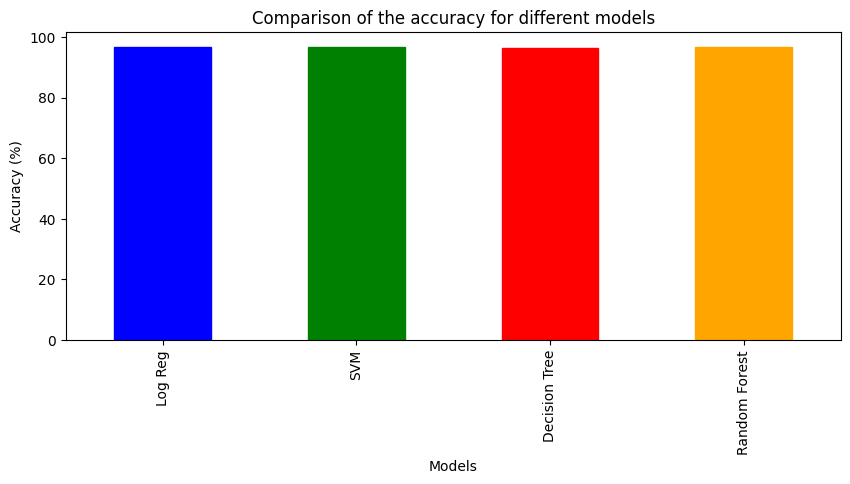

In [111]:
# Create a DataFrame to store the accuracies
plotdata = pd.DataFrame({
    "Accuracy": [logreg_accuracy * 100, svm_accuracy * 100, dt_accuracy * 100, rf_accuracy * 100],
}, index=["Log Reg", "SVM", "Decision Tree", "Random Forest"])

# Define different colors for each bar
colors = ["blue", "green", "red", "orange"]

# Plot the accuracies using a bar chart with different colors
ax = plotdata.plot(kind="bar", figsize=(10, 4), legend=None, color=colors)
plt.title("Comparison of the accuracy for different models")
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")

# Set custom colors for each bar
for i, bar in enumerate(ax.patches):
    bar.set_color(colors[i])

plt.show()


# Models after Random Under Sampling

In [112]:
np.random.shuffle(neg_edges)

num_positive = pos_edges.shape[0]
neg_edges_undersampled = neg_edges[:num_positive]

edges_balanced = np.vstack((pos_edges, neg_edges_undersampled))
labels_balanced = np.concatenate((np.ones(num_positive), np.zeros(num_positive)))

indices = np.arange(edges_balanced.shape[0])
np.random.shuffle(indices)
edges_balanced = edges_balanced[indices]
labels_balanced = labels_balanced[indices]

X_train, X_test, y_train, y_test = train_test_split(edges_balanced, labels_balanced, test_size=0.3)

X_train_embeddings = np.array([node_embeddings_df.loc[node_id]["embedding"] for edge in X_train])
X_test_embeddings = np.array([node_embeddings_df.loc[node_id]["embedding"] for edge in X_test])

In [113]:
print("############################## LOGISTIC REGRESSION #############################")
logreg_model = LogisticRegression()
logreg_model.fit(X_train_embeddings, y_train)

# Predict link existence for the testing set
y_pred = logreg_model.predict(X_test_embeddings)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("\nLog Reg Accuracy:", logreg_accuracy)
print("Classification Report:\n", classification_rep)
print()

print("############################ SUPPORT VECTOR MACHINE #############################")
svm_model = SVC()
svm_model.fit(X_train_embeddings, y_train)

# Predict link existence for the testing set
y_pred = svm_model.predict(X_test_embeddings)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("\nSVM Accuracy:", logreg_accuracy)
print("Classification Report:\n", classification_rep)
print()

print("############################### DECISION TREE ###################################")
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_embeddings, y_train)

# Predict link existence for the testing set
y_pred = dt_model.predict(X_test_embeddings)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("\nDT Accuracy:", logreg_accuracy)
print("Classification Report:\n", classification_rep)
print()
print("################################ RANDOM FOREST #################################")
rf_model = RandomForestClassifier()
rf_model.fit(X_train_embeddings, y_train)

# Predict link existence for the testing set
y_pred = rf_model.predict(X_test_embeddings)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("\nRF Accuracy:", logreg_accuracy)
print("Classification Report:\n", classification_rep)

############################## LOGISTIC REGRESSION #############################

Log Reg Accuracy: 0.4838709677419355
Classification Report:
               precision    recall  f1-score   support

         0.0       0.48      1.00      0.65        30
         1.0       0.00      0.00      0.00        32

    accuracy                           0.48        62
   macro avg       0.24      0.50      0.33        62
weighted avg       0.23      0.48      0.32        62


############################ SUPPORT VECTOR MACHINE #############################

SVM Accuracy: 0.4838709677419355
Classification Report:
               precision    recall  f1-score   support

         0.0       0.48      1.00      0.65        30
         1.0       0.00      0.00      0.00        32

    accuracy                           0.48        62
   macro avg       0.24      0.50      0.33        62
weighted avg       0.23      0.48      0.32        62


############################### DECISION TREE ###############

C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\olivi\anac


RF Accuracy: 0.4838709677419355
Classification Report:
               precision    recall  f1-score   support

         0.0       0.48      1.00      0.65        30
         1.0       0.00      0.00      0.00        32

    accuracy                           0.48        62
   macro avg       0.24      0.50      0.33        62
weighted avg       0.23      0.48      0.32        62



C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Grid Search after Random Under Sampling

In [114]:
# Define hyperparameter grids for each model
logreg_param_grid = {'C': [0.01, 0.1, 1, 10]}
svm_param_grid = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}
dt_param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}

# GridSearchCV for each model
logreg_grid = GridSearchCV(LogisticRegression(), logreg_param_grid, cv=3)
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_param_grid, cv=3)
rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3)

# Fit the models with the best hyperparameters
logreg_grid.fit(X_train_embeddings, y_train)
svm_grid.fit(X_train_embeddings, y_train)
dt_grid.fit(X_train_embeddings, y_train)
rf_grid.fit(X_train_embeddings, y_train)

# Get the best models with their best hyperparameters
best_logreg_model = logreg_grid.best_estimator_
best_svm_model = svm_grid.best_estimator_
best_dt_model = dt_grid.best_estimator_
best_rf_model = rf_grid.best_estimator_

# Predict link existence for the testing set using the best models
y_pred_logreg = best_logreg_model.predict(X_test_embeddings)
y_pred_svm = best_svm_model.predict(X_test_embeddings)
y_pred_dt = best_dt_model.predict(X_test_embeddings)
y_pred_rf = best_rf_model.predict(X_test_embeddings)

# Evaluate the models
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print("Log Reg Accuracy:", logreg_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("DT Accuracy:", dt_accuracy)
print("RF Accuracy:", rf_accuracy)

Log Reg Accuracy: 0.4838709677419355
SVM Accuracy: 0.4838709677419355
DT Accuracy: 0.4838709677419355
RF Accuracy: 0.4838709677419355


# Plot Accuracy

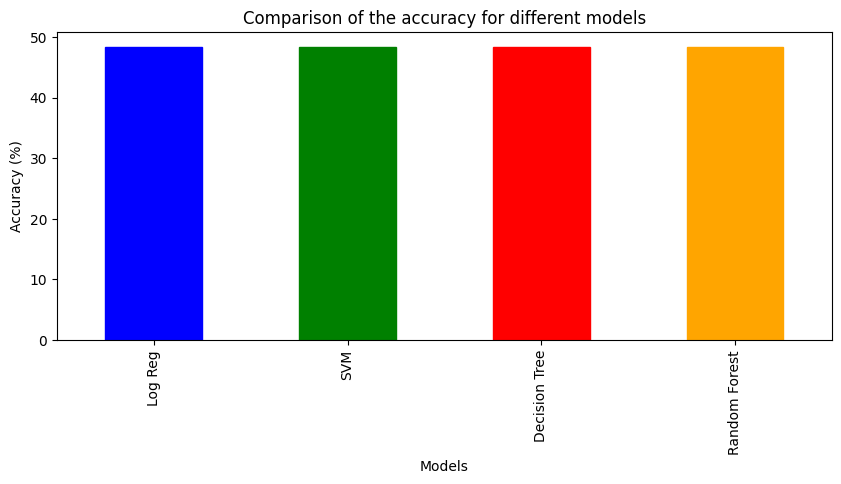

In [115]:
# Create a DataFrame to store the accuracies
plotdata = pd.DataFrame({
    "Accuracy": [logreg_accuracy * 100, svm_accuracy * 100, dt_accuracy * 100, rf_accuracy * 100],
}, index=["Log Reg", "SVM", "Decision Tree", "Random Forest"])

# Define different colors for each bar
colors = ["blue", "green", "red", "orange"]

# Plot the accuracies using a bar chart with different colors
ax = plotdata.plot(kind="bar", figsize=(10, 4), legend=None, color=colors)
plt.title("Comparison of the accuracy for different models")
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")

# Set custom colors for each bar
for i, bar in enumerate(ax.patches):
    bar.set_color(colors[i])

plt.show()